<a href="https://colab.research.google.com/github/ilyesrezgui/ML-Notebooks/blob/master/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was written following Andrej karpathy's course on building a micrograd.
[The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

I have added code blocks to experiment more with the course and commented for better explanation.



In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#We're gonna build a value object
class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.grad=0 # this variable is used to keep track of derivative, being intialized to 0 mean that the gradient  has no effect on the output if we increase it decrease it
    self.data=data
    self._prev=set(_children)
    self._op = _op
    self.label=label

  def __repr__(self):
    #this is a built in method that allows you to print the vlaues of an object by simply calling it, in this case, when you create a value object from the Value class and you
    #initate it with a value1=Value(30) for example , when you call value(1) , it will return a string
    return f"Value(data={self.data})"
  # we defined this __add__ method , because python dosen't know how to add two Value objects, that is why we deined a method with __ so that when we use + python with internally call this method
  def __add__(self,other):
    out= Value(self.data+other.data,(self,other),'+',)
    return out
  def __mul__(self,other):
    out= Value(self.data*other.data,(self,other),'*')
    return out
  def __sub__(self,other):
    out= Value(self.data- other.data,(self,other),'-')
    return out
  def __tanh__(self):
    n=self.data
    out=Value((math.exp(2*n)-1)/(math.exp(2*n)+1),_children=(self,),label="tanh")
    return out




In [7]:
a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10.0,label='c')
e=a*b
e.label='e'
d=e+c
d.label='d'
d._prev # is equal to what are the cildren of d, which are  the result of a*b and c
f=Value(-2.0,label='f')
L=d*f
L.label='L'

In [8]:
d._op

'+'

In [9]:
#at this stage we can say that we're bulding out our own data structure that captures the mathemathical expressions, in addition to the values that resulated in creating an object.

In [10]:
# all this code is written to visualize the graph of nodes
from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s| data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


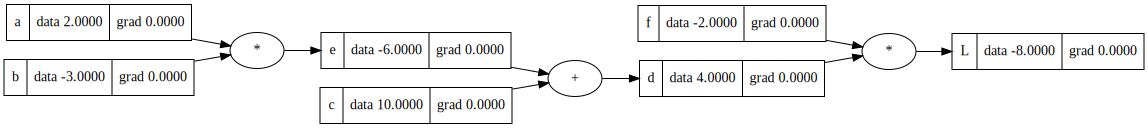

In [11]:
draw_dot(L)
# what we did is build a forward pass that its output is equal to -8
# IN NEURAL NETWORKS WE WILL BE VERY MUCH INTERESTED ON the value of the loss function F with respect to all the weights in the forward pass. so we need to know how these weights
#impact the result L . in other words we will be interested in the value of derivative of L with respect to some of leaf nodes
# Why not with respect to all leaf nodes ? well beacue some of these leaf nodes represnt the data, and the data is fixed so we don't have the need to change it.





# the grad represnt the derivative of the output  "L" with respect to one node
# it is like if i chnage L by a small value h how much would "node" changes

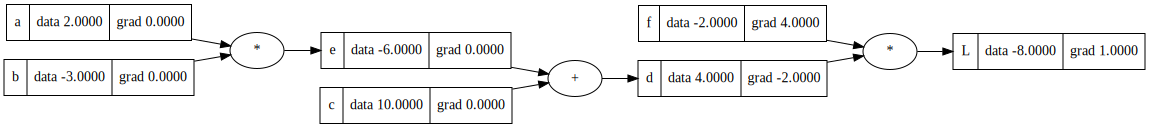

In [12]:
L.grad=1.0
d.grad=-2.0
f.grad=4.0

draw_dot(L)


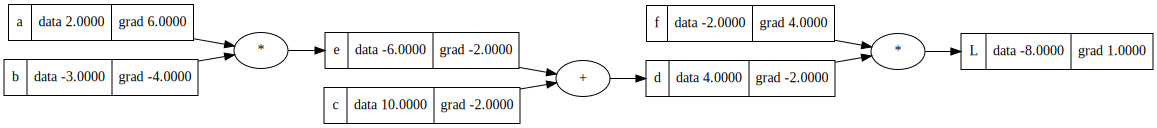

In [13]:
#We got all of these using the chain rule . for practical , if it is a + operation, the local derivative/grad is passed from the grad of it's parent node because grad of node =1 and with teh chain rule 1*parent node = parent node
# and if it a *  operation , simply take the data of sibling node and multiply it by grad of parent node
c.grad=-2.0
e.grad =-2.0
a.grad= 6.0
b.grad= -4.0
draw_dot(L)

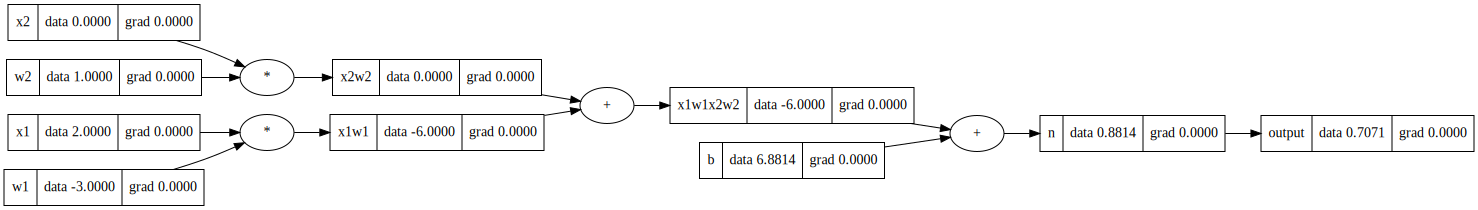

In [22]:
#building a two dim neuron
# we define our inputs
x1=Value(2.0,label="x1")
x2=Value(0.0,label="x2")
# we deine our weights
w1=Value(-3.0,label="w1")
w2=Value(1.0,label="w2")
# we define our bias
b=Value(6.8813735870195432,label="b")
# do the multiplication
x1w1= x1*w1
x1w1.label="x1w1"
x2w2= x2*w2
x2w2.label="x2w2"
x1w1x2w2=x1w1+x2w2
x1w1x2w2.label="x1w1x2w2"
n=x1w1x2w2+b
n.label="n"
# it is worth noting that we need expo in a tanh function, therefore we need to go back and define __expo__ operation on our value class
# another method could be defining a tanh function directly that calculates tanh for a Value object
o=n.__tanh__()
o.label="output"
draw_dot(o)


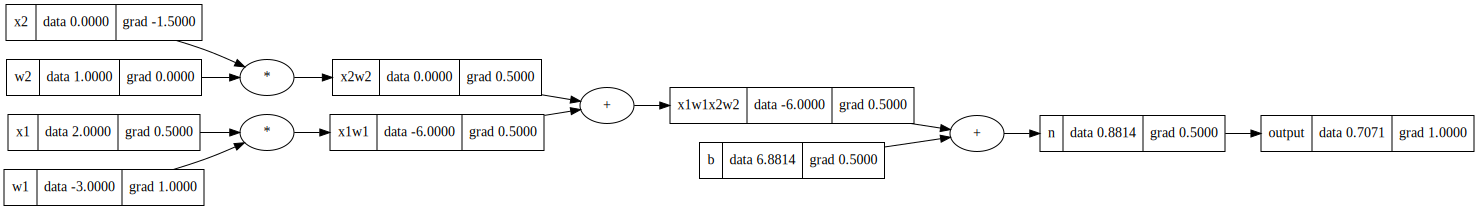

In [27]:
o.grad=1.0
n.grad=0.5 # this was determined using the formulaa of derivative tanh = 1- tanh(n)**2
x1w1x2w2.grad=0.5
b.grad=0.5
x2w2.grad=0.5
x1w1.grad=0.5
x1.grad=0.5
x2.grad=-1.5
w1.grad=1.0
w2.grad=0.0

draw_dot(o)
#if we want to